In [1]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

# Package imports

In [2]:
import matplotlib as mpl

mpl.use("pgf")

#import matplotlib.font_manager as fm

#fp1 = fm.FontProperties(fname='/usr/share/fonts/opentype/linux-libertine/LinLibertine_DR.otf')

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/share/fonts/opentype/linux-libertine/LinLibertine_DR.otf')

rc('text.latex', preamble=[r'\usepackage{libertine}',r'\usepackage[libertine]{newtxmath}'])

#preamble = [
#    r'\usepackage{fontspec}',
#    r'\setmainfont{Linux Libertine O}',
#    r'\usepackage[libertine]{newtxmath}'
#]

#params = {
#    'font.family': 'serif',
#    'text.usetex': True,
#    'text.latex.unicode': True,
#    'pgf.rcfonts': False,
#    'pgf.texsystem': 'xelatex',
#    'pgf.preamble': preamble,
#}

#mpl.rcParams.update(params)

In [3]:
# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(18,10),dpi=100)
%matplotlib inline

# Numba (JiT)
from numba import njit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

# Display progress bars:
from ipywidgets import FloatProgress
from IPython.display import display

# Function that creates directories if they don't exist

In [4]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# Set of implemented fixed step integrators
## Important for saving/loading states

In [5]:
fixed_step_integrators = set(['euler','rk2','rk3','rk4'])

# Function that generates an extended grid of tracers

In [6]:
def padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x_0,dx = np.linspace(x_min,x_max,nx,retstep=True)
    y_0,dy = np.linspace(y_min,y_max,ny,retstep=True)
    
    x = np.empty(nx+4)
    x[0:2] = -2*dx, -dx
    x[2:-2] = x_0
    x[-2:] = x_max+dx, x_max+2*dx
    
    y = np.empty(ny+4)
    y[0:2] = -2*dy, -dy
    y[2:-2] = y_0
    y[-2:] = y_max+dy, y_max+2*dy
    
    nx_ = nx+4
    ny_ = ny+4
    
    grid = np.empty((2,nx_*ny_))
    
    for j in range(nx_):
        grid[0,j*ny_:(j+1)*ny_] = x[j]
        grid[1,j*ny_:(j+1)*ny_] = y
    
    return grid   

# Function which calculates characteristics

In [7]:
def characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride,n_proc=4,atol=None,rtol=None):
    if atol is None:
        atol = 1.e-9
    if rtol is None:
        rtol = 1.e-9
    
    #grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
    dx_main = (x_max-x_min)/(nx-1)
    dy_main = (y_max-y_min)/(ny-1)
    
    dx_aux = np.minimum(1e-5,dx_main*1e-2)
    dy_aux = np.minimum(1e-5,dy_main*1e-2)
    
    _inner_mask = np.zeros((nx+4,ny+4),dtype=np.bool)
    _inner_mask[2:-2,2:-2] = True
    _inner_mask=_inner_mask.reshape((nx+4)*(ny+4))
    
    grid_fin,lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,n_proc,atol,rtol)
    
    return grid_fin[:,_inner_mask],lmbd1[_inner_mask],lmbd2[_inner_mask],hess_lmbd2[_inner_mask],xi1[_inner_mask,:],xi2[_inner_mask,:]

def _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,n_proc,atol,rtol):
    if integrator.__name__ in fixed_step_integrators:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found!')
    else:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found!')
    
    tic = time.time()                              
    
    tens_main,tens_aux = _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux)
    
    lmbd1,lmbd2,xi1,xi2 = _find_characteristics(tens_main,tens_aux)
    
    hess_lmbd2 = _find_hessian(lmbd2,nx,ny,dx_main,dy_main)
                
    mins,secs = np.divmod(time.time()-tic,60)
    
    print('Characteristics calculated in {} minutes and {} seconds'.format(mins,secs))        
    
    return grid[0],lmbd1,lmbd2,hess_lmbd2,xi1,xi2

def _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux):
    grid_main = grid[0].reshape((2,nx+4,ny+4))
    grid_right = grid[1].reshape((2,nx+4,ny+4))
    grid_top = grid[2].reshape((2,nx+4,ny+4))
    grid_left = grid[3].reshape((2,nx+4,ny+4))
    grid_btm = grid[4].reshape((2,nx+4,ny+4))
    
    # Declare Jacobians
    df_m = np.empty((nx+4,ny+4,2,2))
    df_a = np.empty((nx+4,ny+4,2,2))
    
    # Use centered differencing throughout for auxiliary Jacobian:
    df_a[:,:,0,0] = (grid_right[0]-grid_left[0])/(2*dx_aux)
    df_a[:,:,0,1] = (grid_top[0]-grid_btm[0])/(2*dy_aux)
    df_a[:,:,1,0] = (grid_right[1]-grid_left[1])/(2*dx_aux)
    df_a[:,:,1,1] = (grid_top[1]-grid_btm[1])/(2*dy_aux)
    
    # Use centered differencing where applicable for main Jacobian,
    # second order backwards/forwards difference otherwise
    df_m[1:-1,:,0,0] = (grid_main[0,2:,:]-grid_main[0,0:-2,:])/(2*dx_main)
    df_m[0,:,0,0] = (-3*grid_main[0,0,:]+4*grid_main[0,1,:]-2*grid_main[0,2,:])/(2*dx_main)
    df_m[-1,:,0,0] = (3*grid_main[0,-1,:]-4*grid_main[0,-2,:]+2*grid_main[0,-3,:])/(2*dx_main)
    
    df_m[:,1:-1,0,1] = (grid_main[0,:,2:]-grid_main[0,:,0:-2])/(2*dy_main)
    df_m[:,0,0,1] = (-3*grid_main[0,:,0]+4*grid_main[0,:,1]-2*grid_main[0,:,2])/(2*dy_main)
    df_m[:,-1,0,1] = (3*grid_main[0,:,-1]-4*grid_main[0,:,-2]+2*grid_main[0,:,-3])/(2*dy_main)
    
    df_m[1:-1,:,1,0] = (grid_main[1,2:,:]-grid_main[1,0:-2,:])/(2*dx_main)
    df_m[0,:,1,0] = (-3*grid_main[1,0,:]+4*grid_main[1,1,:]-2*grid_main[1,2,:])/(2*dx_main)
    df_m[-1,:,1,0] = (3*grid_main[1,-1,:]-4*grid_main[1,-2,:]+2*grid_main[1,-3,:])/(2*dx_main)
    
    df_m[:,1:-1,1,1] = (grid_main[1,:,2:]-grid_main[1,:,0:-2])/(2*dy_main)
    df_m[:,0,1,1] = (-3*grid_main[1,:,0]+4*grid_main[1,:,1]-2*grid_main[1,:,2])/(2*dy_main)
    df_m[:,-1,1,1] = (3*grid_main[1,:,-1]-4*grid_main[1,:,-2]+2*grid_main[1,:,-3])/(2*dy_main)
    
    # Reshape Jacobian arrays:
    df_a = df_a.reshape(((nx+4)*(ny+4),2,2))
    df_m = df_m.reshape(((nx+4)*(ny+4),2,2))
    
    # Calculate strain tensors:
    c_m = np.matmul(np.transpose(df_m,axes=(0,2,1)),df_m)
    c_a = np.matmul(np.transpose(df_a,axes=(0,2,1)),df_a)
        
    return c_m,c_a

def _find_characteristics(tens_main,tens_aux):
    
    vals = np.linalg.eigvalsh(tens_main)
    bar, vecs = np.linalg.eigh(tens_aux)
    
    lmbd1 = vals[:,0]
    lmbd2 = vals[:,1]
    
    xi1 = vecs[:,:,0]
    xi2 = vecs[:,:,1]
    
    return lmbd1,lmbd2,xi1,xi2

def _find_hessian(lmbd_,nx,ny,dx_main,dy_main):
    lmbd = lmbd_.reshape((nx+4,ny+4))
    
    hessian = np.empty((nx+4,ny+4,2,2))
    
    # First, the laplacian terms:
    
    # Internal points: Centered differences
    hessian[1:-1,:,0,0] = (lmbd[2:,:]-2*lmbd[1:-1,:]+lmbd[:-2,:])/(dx_main**2)
    hessian[:,1:-1,1,1] = (lmbd[:,2:]-2*lmbd[:,1:-1]+lmbd[:,:-2])/(dy_main**2)
    
    # Near boundaries: Higher order forwards/backwards differences
    hessian[0,:,0,0] = (2*lmbd[0,:]-5*lmbd[1,:]+4*lmbd[2,:]-lmbd[3,:])/(dx_main**2)
    hessian[-1,:,0,0] = (2*lmbd[-1,:]-5*lmbd[-2,:]+4*lmbd[-3,:]-lmbd[-4,:])/(dx_main**2)
    
    hessian[:,0,1,1] = (2*lmbd[:,0]-5*lmbd[:,1]+4*lmbd[:,2]-lmbd[:,3])/(dy_main**2)
    hessian[:,-1,1,1] = (2*lmbd[:,-1]-5*lmbd[:,-2]+4*lmbd[:,-3]-lmbd[:,-4])/(dy_main**2)
    
    # Then, the mixed derivatives:
    dldx = np.empty((nx+4,ny+4))
    dldy = np.empty((nx+4,ny+4))
    
    # Internal points: Centered differences
    dldx[1:-1,:] = (lmbd[2:,:]-lmbd[:-2,:])/(2*dx_main)
    dldy[:,1:-1] = (lmbd[:,2:]-lmbd[:,:-2])/(2*dy_main)
    
    # Near boundaries: Higher order forwards/backwards differences
    dldx[0,:] = (-3*lmbd[0,:]+4*lmbd[1,:]-lmbd[2,:])/(2*dx_main)
    dldx[-1,:] = (3*lmbd[-1,:]-4*lmbd[-2,:]+lmbd[-3,:])/(2*dx_main)
    
    dldy[:,0] = (-3*lmbd[:,0]+4*lmbd[:,1]-lmbd[:,2])/(2*dy_main)
    dldy[:,-1] = (3*lmbd[:,-1]-4*lmbd[:,-2]+lmbd[:,-3])/(2*dy_main)
    
    # Same deal for the mixed derivatives
    d2ldxdy = np.empty((nx+4,ny+4))
    d2ldydx = np.empty((nx+4,ny+4))
    
    # Internal points: Centered differences
    d2ldxdy[1:-1,:] = (dldy[2:,:]-dldy[:-2,:])/(2*dx_main)
    d2ldydx[:,1:-1] = (dldx[:,2:]-dldx[:,:-2])/(2*dy_main)
    
    # Near boundaries: Higher order forwards/backwards differences
    d2ldxdy[0,:] = (-3*dldy[0,:]+4*dldy[1,:]-dldy[2,:])/(2*dx_main)
    d2ldxdy[-1,:] = (3*dldy[-1,:]-4*dldy[-2,:]+dldy[3,:])/(2*dx_main)
    
    d2ldydx[:,0] = (-3*dldx[:,0]+4*dldx[:,1]-dldx[:,2])/(2*dy_main)
    d2ldydx[:,-1] = (3*dldx[:,-1]-4*dldx[:,-2]+dldx[:,-3])/(2*dy_main)
    
    hessian[:,:,0,1] = d2ldxdy
    hessian[:,:,1,0] = d2ldydx
    
    return hessian.reshape((nx+4)*(ny+4),2,2)
    

# Define transport parameters

In [8]:
from numerical_integrators.adaptive_step import rkbs32,rkbs54,rkdp54,rkdp87
from numerical_integrators.singlestep import euler,rk2,rk3,rk4
t_start = 0.
t_end = 20.

x_min,x_max = 0,2
y_min,y_max = 0,1

nx,ny = 1000,500

grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max).reshape(2,nx+4,ny+4)[:,2:-2,2:-2].reshape(2,nx*ny)

# Load reference solution

In [9]:
grid_fin_ref,lmbd1_ref,lmbd2_ref,hess_lmbd2_ref,xi1_ref,xi2_ref = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,rkdp87,stride=0.1,n_proc=4,atol=1e-12,rtol=1e-12)

Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.178112030029297 seconds


In [ ]:
grid_fin_ref = np.load('gggg.npy')

In [11]:
xi1_ref.shape

(500000, 2)

In [123]:
grid_fin_ref.shape

(2, 500000)

# Calculate errors of the different advections

In [182]:
singlestep_integrators = [euler,rk2,rk3,rk4]
embedded_integrators = [rkbs32,rkbs54,rkdp54,rkdp87]

singlestep_calls = {'euler': 1,'rk2': 2,'rk3': 3,'rk4': 4}
hs = np.asarray([10**-j for j in range(1,6)])
#for integrator in singlestep_integrators:
#    hs = np.asarray([10**-j for j in range(1,6)])
#    evaluations = np.asarray((20/hs)*singlestep_calls[integrator.__name__])
#    adv_err = np.empty(len(hs))
#    lmbd1_err = np.copy(adv_err)
#    lmbd2_err = np.copy(adv_err)
#    xi1_err = np.copy(adv_err)
#    xi2_err = np.copy(adv_err)
#    rel_adv_err = np.empty(len(hs))
#    rel_lmbd1_err = np.copy(rel_adv_err)
#    rel_lmbd2_err = np.copy(rel_adv_err)
#    rel_xi1_err = np.copy(rel_adv_err)
#    rel_xi2_err = np.copy(rel_adv_err)
#    for j,h in enumerate([0.1,0.01,0.001,0.0001,0.00001]):
#        grid_fin,lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride=h,n_proc=4,atol=1,rtol=1)
#        adv_err[j] = np.mean(np.sqrt((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2))
        #adv_err[j] = np.sqrt(np.mean((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2))
#        lmbd1_err[j] = np.sqrt(np.mean((lmbd1_ref-lmbd1)**2))
#        lmbd2_err[j] = np.sqrt(np.mean((lmbd2_ref-lmbd2)**2))
#        xi1_err[j] = np.sqrt(np.mean((np.arctan2(xi1[1],xi1[0])-np.arctan2(xi1_ref[1],xi1_ref[0]))**2))
#        xi2_err[j] = np.sqrt(np.mean((np.arctan2(xi2[:,1],xi2[:,0])-np.arctan2(xi2_ref[:,1],xi2_ref[:,0]))**2))
        #rel_adv_err[j] = np.mean(np.sqrt((1-grid_fin[0]/grid_fin_ref[0])**2+(1-grid_fin[1]/grid_fin_ref[1])**2))
#        rel_lmbd1_err[j] = np.mean(np.sqrt((1-lmbd1/lmbd1_ref)**2))
#        rel_lmbd2_err[j] = np.mean(np.sqrt((1-lmbd2/lmbd2_ref)**2))
#        rel_xi1_err[j] = np.mean(np.sqrt((1-np.arctan2(xi1[1],xi1[0])/np.arctan2(xi1_ref[1],xi1_ref[0]))**2))
#        rel_xi2_err[j] = np.mean(np.sqrt((1-np.arctan2(xi2[1],xi2[0])/np.arctan2(xi2_ref[1],xi2_ref[0]))**2))
#    ensure_path_exists('errors/{}'.format(integrator.__name__))
#    np.save('errors/{}/adv_errs_abs_kek.npy'.format(integrator.__name__),adv_err)
#    np.save('errors/{}/lmbd1_errs_rms.npy'.format(integrator.__name__),lmbd1_err)
#    np.save('errors/{}/lmbd2_errs_rms.npy'.format(integrator.__name__),lmbd2_err)
#    np.save('errors/{}/xi1_errs_rms.npy'.format(integrator.__name__),xi1_err)
#    np.save('errors/{}/xi2_errs_index_fixed_rms.npy'.format(integrator.__name__),xi2_err)
#    np.save('errors/{}/rel_lmbd1_errs.npy'.format(integrator.__name__),rel_lmbd1_err)
#    np.save('errors/{}/rel_lmbd2_errs.npy'.format(integrator.__name__),rel_lmbd2_err)
#    np.save('errors/{}/rel_xi1_errs.npy'.format(integrator.__name__),rel_xi1_err)
#    np.save('errors/{}/rel_xi2_errs.npy'.format(integrator.__name__),rel_xi2_err)
##    np.save('errors/{}/strides.npy'.format(integrator.__name__),hs)
##    np.save('errors/{}/evaluations.npy'.format(integrator.__name__),evaluations)

In [ ]:
grid_fin,lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,rk4,stride=0.1,n_proc=4,atol=1,rtol=1)

In [49]:
adv_errs = np.sqrt((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2)

plt.hist(adv_errs)

NameError: name 'grid_fin' is not defined

In [113]:
max(adv_errs)

0.015291487904109606

In [11]:
#rel_adv_err

In [183]:
embedded_calls = {'rkbs32': np.array([80,148,344,780,1704,3696,7964,17172,36996,79716]),
                 'rkbs54': np.array([96,120,192,304,480,768,1216,1936,3080,4904]),
                 'rkdp54': np.array([161,168,273,392,588,903,1407,2219,3514,5593]),
                 'rkdp87': np.array([208,234,312,416,572,780,1053,1404,1885,2509])}

tolerances = [10**-j for j in range(1,11)]

#for integrator in embedded_integrators:
#    tolerances = [10**-j for j in range(1,11)]
#    adv_err = np.empty(len(tolerances))
#    lmbd1_err = np.copy(adv_err)
#    lmbd2_err = np.copy(adv_err)
#    xi1_err = np.copy(adv_err)
#    xi2_err = np.copy(adv_err)
    
#    lmbd1_err[0] = np.nan
#    lmbd2_err[0] = np.nan
#    xi1_err[0] = np.nan
#    xi2_err[0] = np.nan
#for j,tol in enumerate(tolerances[1:]):
#    for j,tol in enumerate(tolerances):
#        grid_fin,lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride=0.1,n_proc=4,atol=tol,rtol=tol)
#        adv_err[j] = np.mean(np.sqrt((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2))
#        adv_err[j] = np.sqrt(np.mean((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2))
#        lmbd1_err[j] = np.sqrt(np.mean((lmbd1_ref-lmbd1)**2))
#        lmbd2_err[j] = np.sqrt(np.mean((lmbd2_ref-lmbd2)**2))
#        xi1_err[j] = np.sqrt(np.mean((np.arctan2(xi1_ref[1],xi1_ref[0])-np.arctan2(xi1[1],xi1[0]))**2))
#        xi2_err[j] = np.sqrt(np.mean((np.arctan2(xi2_ref[:,1],xi2_ref[:,0])-np.arctan2(xi2[:,1],xi2[:,0]))**2))
#        adv_err[j+1] = np.mean(np.sqrt((grid_fin_ref[0]-grid_fin[0])**2+(grid_fin_ref[1]-grid_fin[1])**2))
#        lmbd1_err[j+1] = np.mean(np.sqrt((lmbd1_ref-lmbd1)**2))
#        lmbd2_err[j+1] = np.mean(np.sqrt((lmbd2_ref-lmbd2)**2))
#        xi1_err[j+1] = np.mean(np.sqrt((np.arctan2(xi1_ref[1],xi1_ref[0])-np.arctan2(xi1[1],xi1[0]))**2))
#        xi2_err[j+1] = np.mean(np.sqrt((np.arctan2(xi2_ref[1],xi2_ref[0])-np.arctan2(xi2[1],xi2[0]))**2))
#    ensure_path_exists('errors/{}'.format(integrator.__name__))
#    np.save('errors/{}/adv_errs_abs.npy'.format(integrator.__name__),adv_err)
#    np.save('errors/{}/lmbd1_errs_rms.npy'.format(integrator.__name__),lmbd1_err)
#    np.save('errors/{}/lmbd2_errs_rms.npy'.format(integrator.__name__),lmbd2_err)
#    np.save('errors/{}/xi1_errs_rms.npy'.format(integrator.__name__),xi1_err)
#    np.save('errors/{}/xi2_errs_index_fixed_rms.npy'.format(integrator.__name__),xi2_err)
#    np.save('errors/{}/tols.npy'.format(integrator.__name__),tolerances)
#    print('--------------------------------------')
#    np.save('errors/{}/evaluations.npy'.format(integrator.__name__),embedded_calls[integrator.__name__])

# Calculate error in the computed LCSs

## Class definition of the Strainline class

In [11]:
class Strainline:
    def __init__(self,startpoint,l_min,l_f_max,lmbd2_spline):
        self.pos = np.array([startpoint]).reshape((2,1))
        self.l_min = l_min
        self.lmbd2_spline = lmbd2_spline
        self.stationary = np.zeros(2,dtype=np.bool)
        self.cont_failure = np.zeros(2,dtype=np.bool)
        self.outs_dom = np.zeros(2,dtype=np.bool)
        self.max_iter = np.zeros(2,dtype=np.bool)
        self.startpoint_index = 0
        self.tailcut_start = 0
        self.tailcut_end = 0
    def long_enough(self):
        return self.len >= self.l_min
    def append(self,pos):
        self.pos = np.hstack((self.pos,pos.reshape((2,1))))
    def traj(self):
        return self.pos
    def avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.pos[1],self.pos[0]))
    def lngth(self):
        return np.sum(np.sqrt((np.diff(self.pos,axis=1)**2).sum(axis=0)))
    def tailcut_traj(self):
        return self.pos[:,self.tailcut_start:self.tailcut_end]
    def tailcut_avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.tailcut_traj()[1],self.tailcut_traj()[0]))
    def tailcut_lngth(self):
        return np.sum(np.sqrt((np.diff(self.tailcut_traj(),axis=1)**2).sum(axis=0)))

## Singlestep runs

In [12]:
LCS_ref = np.load('precomputed_lcs/rkdp87/lcs_atol=1e-12_rtol=1e-12_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy')
LCS_traj_ref = np.hstack(([LCS.tailcut_traj() for LCS in LCS_ref]))

## False positives

In [12]:
LCS_ref[0].tailcut_traj().shape

(2, 3740)

In [90]:
thresh = 0
intstep = 0.001

for integrator in singlestep_integrators:
    LCS_fp_fp = np.zeros((len(hs)))
    LCS_fp_nn = np.zeros((len(hs)))
    for j, h in enumerate(hs):
        LCS_curr = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,h))
        LCS_traj = np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr]))
        dists = np.asarray([np.min(np.sqrt((LCS_traj_ref[0]-LCS_traj[0,i])**2+(LCS_traj_ref[1]-LCS_traj[1,i])**2)) for i in range(LCS_traj.shape[1])])
        LCS_fp_fp[j] = np.sum(dists[dists>thresh]*intstep)
        LCS_fp_nn[j] = np.sqrt(np.mean(dists[dists<=thresh]**2))
    ensure_path_exists('errors/{}'.format(integrator.__name__))
    np.save('errors/{}/lcs_errs_rms_fp_fp_thresh={}.npy'.format(integrator.__name__,thresh),LCS_fp_fp)
    np.save('errors/{}/lcs_errs_rms_fp_nn_thresh={}.npy'.format(integrator.__name__,thresh),LCS_fp_nn)
        

In [19]:
intstep = 0.001

In [91]:
for integrator in singlestep_integrators:
    LCS_fn_fn = np.zeros((len(hs)))
    LCS_fn_nn = np.zeros((len(hs)))
    for j, h in enumerate(hs):
        LCS_curr = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,h))
        LCS_traj = np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr]))
        dists = np.asarray([np.min(np.sqrt((LCS_traj_ref[0,i]-LCS_traj[0])**2+(LCS_traj_ref[1,i]-LCS_traj[1])**2)) for i in range(LCS_traj_ref.shape[1])])
        LCS_fn_fn[j] = np.sum(dists[dists>thresh]*intstep)
        LCS_fn_nn[j] = np.sqrt(np.mean(dists[dists<=thresh]**2))
    ensure_path_exists('errors/{}'.format(integrator.__name__))
    np.save('errors/{}/lcs_errs_rms_fn_fn_thresh={}.npy'.format(integrator.__name__,thresh),LCS_fn_fn)
    np.save('errors/{}/lcs_errs_rms_fn_nn_thresh={}.npy'.format(integrator.__name__,thresh),LCS_fn_nn)


In [184]:
singlestep_lcs_fp_fp = [np.load('errors/{}/lcs_errs_rms_fp_fp.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
singlestep_lcs_fp_nn = [np.load('errors/{}/lcs_errs_rms_fp_nn.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
singlestep_lcs_fn_fn = [np.load('errors/{}/lcs_errs_rms_fn_fn.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
singlestep_lcs_fn_nn = [np.load('errors/{}/lcs_errs_rms_fn_nn.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]



embedded_lcs_fp_fp = [np.load('errors/{}/lcs_errs_rms_fp_fp.npy'.format(integrator.__name__)) for integrator in embedded_integrators]
embedded_lcs_fp_nn = [np.load('errors/{}/lcs_errs_rms_fp_nn.npy'.format(integrator.__name__)) for integrator in embedded_integrators]
embedded_lcs_fn_fn = [np.load('errors/{}/lcs_errs_rms_fn_fn.npy'.format(integrator.__name__)) for integrator in embedded_integrators]
embedded_lcs_fn_nn = [np.load('errors/{}/lcs_errs_rms_fn_nn.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

In [96]:
# Thresh = 0:
singlestep_lcs_fp_fp = [np.load('errors/{}/lcs_errs_rms_fp_fp_thresh=0.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
singlestep_lcs_fp_nn = [np.load('errors/{}/lcs_errs_rms_fp_nn_thresh=0.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
singlestep_lcs_fn_fn = [np.load('errors/{}/lcs_errs_rms_fn_fn_thresh=0.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
singlestep_lcs_fn_nn = [np.load('errors/{}/lcs_errs_rms_fn_nn_thresh=0.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]



embedded_lcs_fp_fp = [np.load('errors/{}/lcs_errs_rms_fp_fp_thresh=0.npy'.format(integrator.__name__)) for integrator in embedded_integrators]
embedded_lcs_fp_nn = [np.load('errors/{}/lcs_errs_rms_fp_nn_thresh=0.npy'.format(integrator.__name__)) for integrator in embedded_integrators]
embedded_lcs_fn_fn = [np.load('errors/{}/lcs_errs_rms_fn_fn_thresh=0.npy'.format(integrator.__name__)) for integrator in embedded_integrators]
embedded_lcs_fn_nn = [np.load('errors/{}/lcs_errs_rms_fn_nn_thresh=0.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

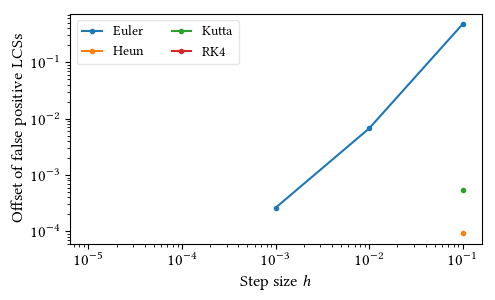

In [186]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [1e-1,9e-1,7e0,4e1]

for j,err in enumerate(singlestep_lcs_fp_fp):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-10,1e-1)
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Step size $h$',fontsize=12)
plot.set_ylabel(r'Offset of false positive LCSs',fontsize=12)
plt.tight_layout()
#plt.title(r'$\textnormal{{Thresh}}={}$'.format(thresh))
#plt.savefig('/home/arne/Desktop/lcs_errors_fixed_steplength_fp_fp_thresh=0.png',dpi=350)
#plt.savefig('error_plots/lcs_errors_fixed_steplength_fp_fp.pgf')

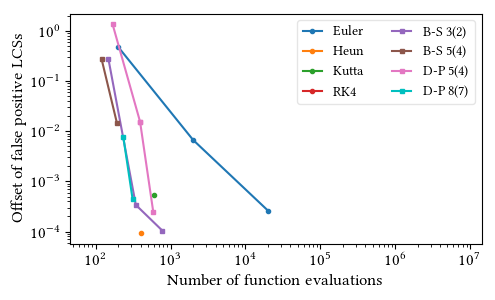

In [193]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_lcs_fp_fp)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations[:-1],embedded_lcs_fp_fp[:-1])):
    plot.plot(evs,err,marker='s',markersize=3,label='{}'.format(enames[j]))
plot.plot(embedded_evaluations[j+1],embedded_lcs_fp_fp[j+1],color='c',marker='s',markersize=3,label='{}'.format(enames[j+1]))

    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Number of function evaluations',fontsize=12)
plot.set_ylabel(r'Offset of false positive LCSs',fontsize=12)
plt.tight_layout()
#plt.title(r'$\textnormal{{Thresh}}={}$'.format(thresh))
#plt.savefig('/home/arne/Desktop/lcs_errors_both_fp_fp_thresh=0.png',dpi=350)
#teplt.savefig('error_plots/lcs_errors_both_fp_fp.pgf')

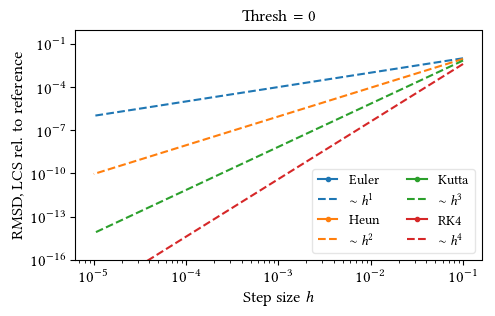

In [103]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [1e-1,9e-1,7e0,4e1]

for j,err in enumerate(singlestep_lcs_fp_nn):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-10,1e-1)
plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Step size $h$',fontsize=12)
plot.set_ylabel(r'RMSD, LCS rel. to reference',fontsize=12)
plt.tight_layout()
plt.title(r'$\textnormal{{Thresh}}={}$'.format(thresh))
plt.savefig('/home/arne/Desktop/lcs_errors_fixed_steplength_fp_nn_thresh=0.png',dpi=350)
#plt.savefig('error_plots/lcs_errors_fixed_steplength_fp_nn.pgf')

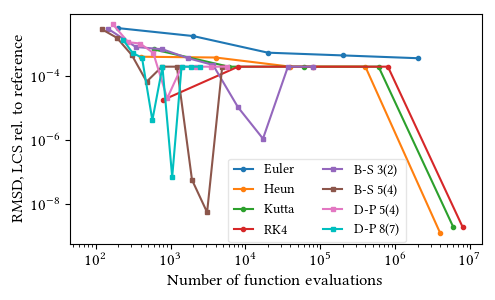

In [204]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_lcs_fp_nn)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations[:-1],embedded_lcs_fp_nn[:-1])):
    plot.plot(evs,err,marker='s',markersize=3,label='{}'.format(enames[j]))
plot.plot(embedded_evaluations[j+1],embedded_lcs_fp_nn[j+1],color='c',marker='s',markersize=3,label='{}'.format(enames[j+1]))
    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_xlim(4e1,1e6)
#plot.set_ylim(1e-16,1)
leg = plot.legend(bbox_to_anchor=(0.6, -0.025),loc='lower center', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Number of function evaluations',fontsize=12)
plot.set_ylabel(r'RMSD, LCS rel. to reference',fontsize=12)
plt.tight_layout()
#plt.title(r'$\textnormal{{Thresh}}={}$'.format(thresh))
#plt.savefig('/home/arne/Desktop/lcs_errors_both_fp_nn_thresh=0.png',dpi=350)
#plt.savefig('error_plots/lcs_errors_both_fp_nn.pgf')

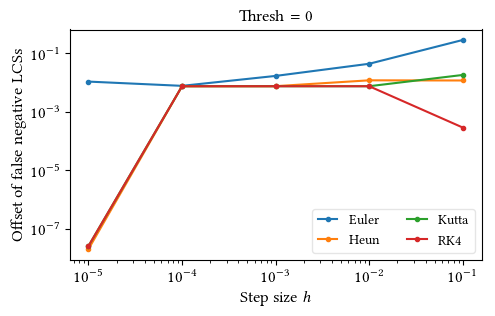

In [106]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [1e-1,9e-1,7e0,4e1]

for j,err in enumerate(singlestep_lcs_fn_fn):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-10,1e-1)
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Step size $h$',fontsize=12)
plot.set_ylabel(r'Offset of false negative LCSs',fontsize=12)
plt.tight_layout()
plt.title(r'$\textnormal{{Thresh}}={}$'.format(thresh))
#plt.savefig('/home/arne/Desktop/lcs_errors_fixed_steplength_fn_fn_thresh=0.png',dpi=350)
#plt.savefig('error_plots/lcs_errors_fixed_steplength_fn_fn.pgf')

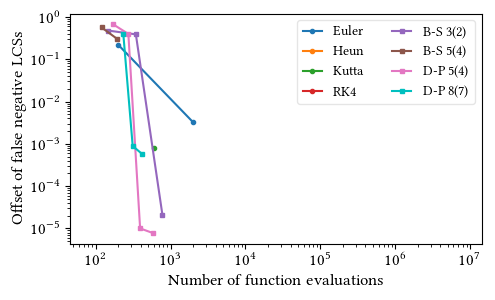

In [203]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_lcs_fn_fn)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations[:-1],embedded_lcs_fn_fn[:-1])):
    plot.plot(evs,err,marker='s',markersize=3,label='{}'.format(enames[j]))
plot.plot(embedded_evaluations[j+1],embedded_lcs_fn_fn[j+1],color='c',marker='s',markersize=3,label='{}'.format(enames[j+1]))
    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_xlim(4e1,1e6)
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Number of function evaluations',fontsize=12)
plot.set_ylabel(r'Offset of false negative LCSs',fontsize=12)
plt.tight_layout()
#plt.title(r'$\textnormal{{Thresh}}={}$'.format(thresh))
#plt.savefig('/home/arne/Desktop/lcs_errors_both_fn_fn_thresh=0.png',dpi=350)
#plt.savefig('error_plots/lcs_errors_both_fn_fn.pgf')

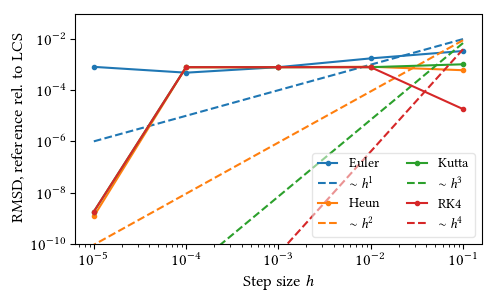

In [129]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [1e-1,9e-1,7e0,4e1]

for j,err in enumerate(singlestep_lcs_fn_nn):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-10,1e-1)
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Step size $h$',fontsize=12)
plot.set_ylabel(r'RMSD, reference rel. to LCS',fontsize=12)
plt.tight_layout()
#plt.title(r'$\textnormal{{Thresh}}={}$'.format(thresh))
#plt.savefig('/home/arne/Desktop/lcs_errors_fixed_steplength_fn_nn_thresh=0.png',dpi=350)
#plt.savefig('error_plots/lcs_errors_fixed_steplength_fn_nn.pgf')

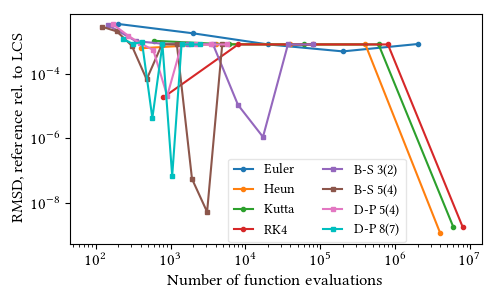

In [205]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_lcs_fn_nn)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations[:-1],embedded_lcs_fn_nn[:-1])):
    plot.plot(evs,err,marker='s',markersize=3,label='{}'.format(enames[j]))
plot.plot(embedded_evaluations[j+1],embedded_lcs_fn_nn[j+1],color='c',marker='s',markersize=3,label='{}'.format(enames[j+1]))

    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_xlim(4e1,1e6)
#plot.set_ylim(1e-16,1)
leg = plot.legend(bbox_to_anchor=(0.6, -0.025),loc='lower center', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Number of function evaluations',fontsize=12)
plot.set_ylabel(r'RMSD, reference rel. to LCS',fontsize=12)
plt.tight_layout()
#plt.title(r'$\textnormal{{Thresh}}={}$'.format(thresh))
#plt.savefig('/home/arne/Desktop/lcs_errors_both_fn_nn_thresh=0.png',dpi=350)
#plt.savefig('error_plots/lcs_errors_both_fn_nn.pgf')

# Embedded runs

[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10]

In [92]:
thresh = 0#0.01
intstep = 0.001

for integrator in embedded_integrators:
    LCS_fp_fp = np.zeros((len(tolerances)))
    LCS_fp_nn = np.zeros((len(tolerances)))
    for j, tol in enumerate(tolerances[1:]):
        LCS_curr = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,tol,tol))
        LCS_traj = np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr]))
        dists = np.asarray([np.min(np.sqrt((LCS_traj_ref[0]-LCS_traj[0,i])**2+(LCS_traj_ref[1]-LCS_traj[1,i])**2)) for i in range(LCS_traj.shape[1])])
        LCS_fp_fp[j+1] = np.sum(dists[dists>thresh]*intstep)
        LCS_fp_nn[j+1] = np.sqrt(np.mean(dists[dists<=thresh]**2))
    ensure_path_exists('errors/{}'.format(integrator.__name__))
    np.save('errors/{}/lcs_errs_rms_fp_fp_thresh={}.npy'.format(integrator.__name__,thresh),LCS_fp_fp)
    np.save('errors/{}/lcs_errs_rms_fp_nn_thresh={}.npy'.format(integrator.__name__,thresh),LCS_fp_nn)

/home/arne/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arne/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [93]:
thresh = 0#0.01
intstep = 0.001

for integrator in embedded_integrators:
    LCS_fp_fp = np.zeros((len(tolerances)))
    LCS_fp_nn = np.zeros((len(tolerances)))
    for j, tol in enumerate(tolerances[1:]):
        LCS_curr = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,tol,tol))
        LCS_traj = np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr]))
        dists = np.asarray([np.min(np.sqrt((LCS_traj_ref[0,i]-LCS_traj[0])**2+(LCS_traj_ref[1,i]-LCS_traj[1])**2)) for i in range(LCS_traj_ref.shape[1])])
        LCS_fp_fp[j+1] = np.sum(dists[dists>thresh]*intstep)
        LCS_fp_nn[j+1] = np.sqrt(np.mean(dists[dists<=thresh]**2))
    ensure_path_exists('errors/{}'.format(integrator.__name__))
    np.save('errors/{}/lcs_errs_rms_fn_fn_thresh={}.npy'.format(integrator.__name__,thresh),LCS_fp_fp)
    np.save('errors/{}/lcs_errs_rms_fn_nn_thresh={}.npy'.format(integrator.__name__,thresh),LCS_fp_nn)

/home/arne/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arne/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [46]:
#LCS_ref = np.load('precomputed_lcs/rkdp87/lcs_atol=1e-12_rtol=1e-12_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy')
#LCS_traj_ref = np.hstack(([LCS.tailcut_traj() for LCS in LCS_ref]))
for integrator in singlestep_integrators:
    LCS_errors = np.empty(len(hs))
    for j,h in enumerate(hs):
        LCS_curr = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,h))
        LCS_traj = np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr]))
        LCS_errors[j] = np.sqrt(np.mean([np.min(((LCS_traj_ref[0]-LCS_traj[0,i])**2+(LCS_traj_ref[1]-LCS_traj[1,i])**2)) for i in range(LCS_traj.shape[1])]))
    ensure_path_exists('errors/{}'.format(integrator.__name__))
    np.save('errors/{}/lcs_errs_rms.npy'.format(integrator.__name__),LCS_errors)
        

In [ ]:
j_int = 3
integrator = singlestep_integrators[j_int]
trajs = []
for h in (hs):
    LCS_curr = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,h))
    trajs.append(np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr])))

# Embedded runs

In [47]:
LCS_ref = np.load('precomputed_lcs/rkdp87/lcs_atol=1e-12_rtol=1e-12_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy')
LCS_traj_ref = np.hstack(([LCS.tailcut_traj() for LCS in LCS_ref]))
trajs = []
for integrator in embedded_integrators:
    LCS_errors = np.empty(len(tolerances))
    LCS_errors[0]=np.nan
    for j,tol in enumerate(tolerances[1:]):
        LCS_curr = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,tol,tol))
        LCS_traj = np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr]))
        trajs.append(LCS_traj)
        LCS_errors[j+1] = np.sqrt(np.mean([np.min((LCS_traj_ref[0]-LCS_traj[0,i])**2+(LCS_traj_ref[1]-LCS_traj[1,i])**2) for i in range(LCS_traj.shape[1])]))
    ensure_path_exists('errors/{}'.format(integrator.__name__))
    np.save('errors/{}/lcs_errs_rms.npy'.format(integrator.__name__),LCS_errors)
        

In [58]:
LCS_ref = np.load('precomputed_lcs/rkdp87/lcs_atol=1e-12_rtol=1e-12_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy')

In [ ]:
integrator.__name__

In [ ]:
fig = plt.figure(1)
plot = fig.add_subplot(111)
plot.scatter(LCS_traj_ref[0],LCS_traj_ref[1],s=1,marker='.',c='tomato',label=r'Reference')
for j in range(4,-1,-1):
    plot.scatter(trajs[j][0],trajs[j][1],s=1.,marker='.',label=r'$h={}$'.format(hs[j]))

leg = plot.legend(bbox_to_anchor=(0.75, 1), loc='upper left', ncol=1,fontsize=25,markerscale=8)
leg.get_frame().set_alpha(0.5)
plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,2)
plt.ylim(0,1)
plt.tight_layout()
#plt.savefig('lcs_figures/{}.pdf'.format(integrator.__name__))

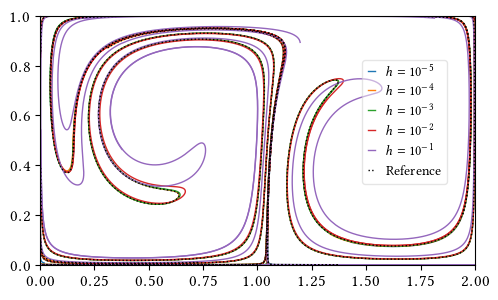

In [65]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)
#l, = plot.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],lw=1,c='tomato',label=r'\textnormal{Reference}')
#for LCS in LCS_ref[1:]:
#    plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')  
j_int = 0
integrator = singlestep_integrators[j_int]
for counter,h in enumerate(hs[::-1]):
    LCS_curr = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,h))
    l, = plot.plot(LCS_curr[0].tailcut_traj()[0],LCS_curr[0].tailcut_traj()[1],lw=1,label=r'$h=10^{{{{-}}{}}}$'.format(5-counter))
    for LCS in LCS_curr[1:]:
        plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')
l, = plot.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],':',lw=1,c='k',label=r'\textnormal{Reference}')
for LCS in LCS_ref[1:]:
    plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],':',lw=1,c=l.get_color(),label='_nolegend_')  
leg = plot.legend(bbox_to_anchor=(0.725, 0.85), loc='upper left', ncol=1,fontsize=10,markerscale=4,handlelength=0.5)
leg.get_frame().set_alpha(0.5)
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,2)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('lcs_figures/{}.pgf'.format(integrator.__name__))
#plt.savefig('lcs_figures/{}.png'.format(integrator.__name__),dpi=350)


## Embedded runs

In [ ]:
j_int = 3
integrator = embedded_integrators[j_int]
trajs = []
for tol in tolerances[1:]:
    LCS_curr = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,tol,tol))
    trajs.append(np.hstack(([LCS.tailcut_traj() for LCS in LCS_curr])))

In [ ]:
np.shape(trajs[1])

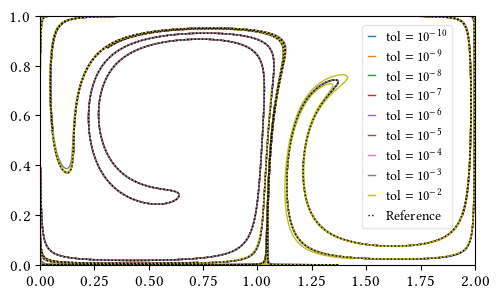

In [71]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)
#l, = plot.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],lw=1,c='tomato',label=r'\textnormal{Reference}')
#for LCS in LCS_ref[1:]:
#    plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')  
j_int = 3
integrator = embedded_integrators[j_int]
for counter,tol in enumerate(tolerances[9:0:-1]):
    LCS_curr = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,tol,tol))
    l, = plot.plot(LCS_curr[0].tailcut_traj()[0],LCS_curr[0].tailcut_traj()[1],lw=1,label=r'$\textnormal{{tol}}=10^{{{{-}}{}}}$'.format(10-counter))
    for LCS in LCS_curr[1:]:
        plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')
l, = plot.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],':',lw=1,c='k',label=r'\textnormal{Reference}')
for LCS in LCS_ref[1:]:
    plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],':',lw=1,c=l.get_color(),label='_nolegend_')  

        
leg = plot.legend(bbox_to_anchor=(0.725, 0.99), loc='upper left', ncol=1,fontsize=10,markerscale=4,handlelength=0.5)
leg.get_frame().set_alpha(0.5)
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,2)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('lcs_figures/{}.pgf'.format(integrator.__name__))
#plt.savefig('lcs_figures/{}.png'.format(integrator.__name__),dpi=350)


In [ ]:
fig = plt.figure(1)
plot = fig.add_subplot(111)
plot.scatter(LCS_traj_ref[0],LCS_traj_ref[1],s=1,marker='.',c='tomato',label=r'Reference')
for j in range(8,-1,-1):
    plot.scatter(trajs[j][0],trajs[j][1],s=1.,marker='.',label=r'tol $={}$'.format(tolerances[j+1]))

    
leg = plot.legend(bbox_to_anchor=(0.75, 0.8), loc='upper left', ncol=1,fontsize=25,markerscale=8)
leg.get_frame().set_alpha(0.5)
plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,2)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('lcs_figures/{}.pgf'.format(integrator.__name__))

In [ ]:
j_int = 0
j_sstep = 0
integrator = singlestep_integrators[j_int]

LCSs = np.load('precomputed_lcs/{}/lcs_h={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,hs[j_sstep]))

In [ ]:
def find_ab_mask(lmbd1,lmbd2,hess_lmbd2,xi2):
    return np.logical_and(_a_true(lmbd1,lmbd2),_b_true(hess_lmbd2,xi2))

def _a_true(lmbd1,lmbd2):
    return np.logical_and(np.less(lmbd1,lmbd2),np.greater(lmbd2,1))

def _b_true(hess_lmbd2,xi2):
    #tf = np.zeros(hess_lmbd2.shape[0],dtype=np.bool)
    #for j in range(len(tf)):
    #    if np.dot(xi2[j],np.dot(hess_lmbd2[j],xi2[j])) <=0:
    #        tf[j] = True
    #return tf
    return np.less_equal(np.sum(xi2*np.sum(hess_lmbd2*xi2[...,np.newaxis],axis=1),axis=1),0)

In [ ]:
tolz = 1e-1

j_int = 3
integrator = embedded_integrators[j_int]

gf,lf1,lf2,hl2,xf1,xf2 = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride=0.1,n_proc=4,atol=tolz,rtol=tolz)

msk_ba = find_ab_mask(lf1,lf2,hl2,xf2)

g = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max).reshape((2,nx+4,ny+4))[:,2:-2,2:-2].reshape((2,nx*ny))

fig = plt.figure(1)
plot = fig.add_subplot(111)

cm = mpl.colors.ListedColormap(['white','steelblue'])

plot.imshow(msk_ba.reshape(nx,ny),origin='lower')
#cnt = plot.contour(g.reshape(2,nx,ny)[0,:,0],g.reshape(2,nx,ny)[1,0,:],msk_ba.reshape(nx,ny).T,cmap=cm,lw=0,antialiased=False,rasterized=True)
#for c in cnt.collections:
#    c.set_edgecolor("face")
#plt.scatter(g0[0],g0[1],c='k',s=1,marker='.')
plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_xlim(0,2)
plot.set_ylim(0,1)
plt.tight_layout()
#plt.savefig('domain_figures/{}_tol={}.pgf'.format(integrator.__name__,tolz))

In [ ]:
integrator

In [ ]:
traj_ref = np.hstack(([LCS.tailcut_traj() for LCS in LCSs_ref]))

In [ ]:
traj_inv = np.hstack(([LCS.tailcut_traj() for LCS in LCSs]))

In [ ]:
trajerrinpos = np.mean([np.min(np.sqrt((traj_inv[0,j]-traj_ref[0])**2+(traj_inv[1,j]-traj_ref[1])**2))for j in range(traj_inv.shape[1])])

In [ ]:
trajerrinpos

In [ ]:
#dct = {0: 1, 1: 0, 2: 3, 3: 4: 6}

In [ ]:
print(LCSs_ref[j_lcs_ref].traj().shape)
print(LCSs[j_lcs_cur].traj().shape)

In [ ]:
plt.scatter(traj_ref[0],traj_ref[1],s=1,marker='.',c='steelblue')

In [ ]:
print(LCSs_ref[j_lcs_ref].traj()[:,LCSs_ref[j_lcs_ref].startpoint_index])
print(LCSs[j_lcs_cur].traj()[:,LCSs[j_lcs_cur].startpoint_index])

In [ ]:
for LCS in LCSs:
    plt.scatter(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],s=1,marker='.',c='steelblue')
plt.xlim(-0.02,2.02)
plt.ylim(-0.01,1.01)

In [ ]:
for LCS in LCSs_ref:
    plt.scatter(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],s=1,marker='.',c='tomato')
plt.xlim(-0.02,2.02)
plt.ylim(-0.01,1.01)

## Embedded runs

In [ ]:
integrator=rkbs54

In [ ]:
plt.semilogy(embedded_calls[integrator.__name__],lmbd2_err,marker='o')
plt.semilogy(embedded_calls[rkbs32.__name__],np.load('errors/{}/lmbd2_errs.npy'.format(rkbs32.__name__)),marker='o')

In [ ]:
lmbd1_err

In [ ]:
plt.loglog(hs,lmbd1_err)

# Error in advection

In [157]:
singlestep_adv_errs = [np.load('errors/{}/adv_errs_rms.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_adv_errs = [np.load('errors/{}/adv_errs_rms.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

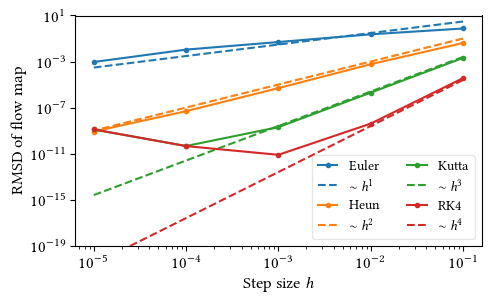

In [78]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [3e1,1e1,2.5e0,2.5e-1]

for j,err in enumerate(singlestep_adv_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-19,10)
leg = plot.legend(loc='lower right', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Step size $h$',fontsize=12)
plot.set_ylabel(r'RMSD of flow map',fontsize=12)
plt.tight_layout()
#plt.savefig('/home/arne/Desktop/11.png',dpi=350)
#plt.savefig('error_plots/advection_errors_fixed_steplength.pgf')
#plt.savefig('error_plots/advection_errors_fixed_steplength.png',dpi=350)

In [188]:
singlestep_evaluations = [np.load('errors/{}/evaluations.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_evaluations = [np.load('errors/{}/evaluations.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

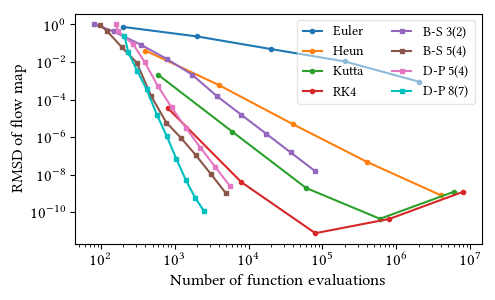

In [158]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_adv_errs)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations[:-1],embedded_adv_errs[:-1])):
    plot.plot(evs,err,marker='s',markersize=3,label='{}'.format(enames[j]))
plot.plot(embedded_evaluations[j+1],embedded_adv_errs[j+1],color='c',marker='s',markersize=3,label='{}'.format(enames[j+1]))
    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Number of function evaluations',fontsize=12)
plot.set_ylabel(r'RMSD of flow map',fontsize=12)
plt.tight_layout()
plt.savefig('error_plots/advection_errors_fixed_and_adaptive_steplength.pgf')

# Testrun: Mean Euclidean distance

In [143]:
#singlestep_adv_errs = [np.load('errors/{}/adv_errs_abs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
#embedded_adv_errs = [np.load('errors/{}/adv_errs_abs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

In [102]:
#fig = plt.figure(1,figsize=(5.05,3.1))
#plot = fig.add_subplot(111)

#names = ['Euler','Heun','Kutta','RK4']
#scales = [3e1,1e1,2.5e0,2.5e-1]

#for j,err in enumerate(singlestep_adv_errs):
#    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
#    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
#plot.tick_params(axis='both', which='major', labelsize=12)
#plot.tick_params(axis='both', which='minor', labelsize=10)
#plot.set_yscale('log')
#plot.set_xscale('log')
#plot.set_ylim(1e-19,10)
#leg = plot.legend(loc='lower right', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
#leg.get_frame().set_alpha(0.5)
#plot.set_xlabel(r'Step size $h$',fontsize=12)
#plot.set_ylabel(r'RMSD of flow map',fontsize=12)
#plt.tight_layout()
#plt.savefig('error_plots/advection_errors_fixed_steplength.pgf')
#plt.savefig('error_plots/advection_errors_fixed_steplength.png',dpi=350)

In [103]:
#fig = plt.figure(1,figsize=(5.05,3.1))
#plot = fig.add_subplot(111)

#snames = ['Euler','Heun','Kutta','RK4']
#enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

#for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_adv_errs)):
#    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
#for j,(evs,err) in enumerate(zip(embedded_evaluations,embedded_adv_errs)):
#    plot.plot(evs,err,marker='.',label='{}'.format(enames[j]))

#    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
#    
#plot.tick_params(axis='both', which='major', labelsize=12)
#plot.tick_params(axis='both', which='minor', labelsize=10)
#plot.set_yscale('log')
#plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
#leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
#leg.get_frame().set_alpha(0.5)
#plot.set_xlabel(r'Number of function evaluations',fontsize=12)
#plot.set_ylabel(r'RMSD of flow map',fontsize=12)
#plt.tight_layout()
#plt.savefig('error_plots/advection_errors_fixed_and_adaptive_steplength.pgf')

# Error in $\lambda_{1}$

In [34]:
singlestep_lmbd1_errs = [np.load('errors/{}/rel_lmbd1_errs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_lmbd1_errs = [np.load('errors/{}/lmbd1_errs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

In [ ]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [8e5,2e2,3e1,7e1]

for j,err in enumerate(singlestep_lmbd1_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-10,1e2)
plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Step size $h$',fontsize=20)
plot.set_ylabel(r'Mean rel. error in $\lambda_{1}$',fontsize=20)
plt.tight_layout()
plt.savefig('error_plots/eigenvalue1_rel_errors_fixed_steplength.png',dpi=100)

In [ ]:
np.shape(singlestep_lmbd1_errs)

# Error in $\lambda_{2}$

In [152]:
singlestep_lmbd2_errs = [np.load('errors/{}/lmbd2_errs_rms.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_lmbd2_errs = [np.load('errors/{}/lmbd2_errs_rms.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

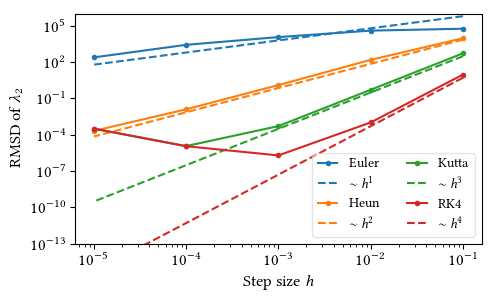

In [79]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [6e6,7e5,3e5,5e4]

for j,err in enumerate(singlestep_lmbd2_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-13,1e6)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Step size $h$',fontsize=12)
plot.set_ylabel(r'RMSD of $\lambda_{2}$',fontsize=12)
plt.tight_layout()
plt.savefig('error_plots/eigenvalue2_errors_fixed_steplength.pgf')

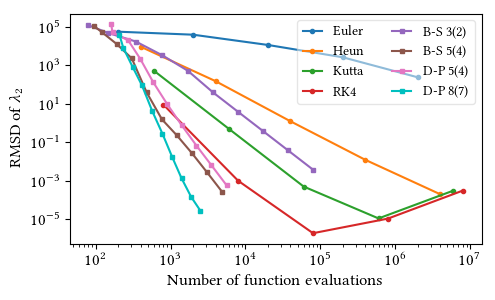

In [155]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_lmbd2_errs)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations[:-1],embedded_lmbd2_errs[:-1])):
    plot.plot(evs,err,marker='s',markersize=3,label='{}'.format(enames[j]))
plot.plot(embedded_evaluations[j+1],embedded_lmbd2_errs[j+1],color='c',marker='s',markersize=3,label='{}'.format(enames[j+1]))

    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Number of function evaluations',fontsize=12)
plot.set_ylabel(r'RMSD of $\lambda_{2}$',fontsize=12)
plt.tight_layout()
plt.savefig('error_plots/eigenvalue2_errors_fixed_and_adaptive_steplength.pgf')

In [41]:
#singlestep_lmbd2_errs = [np.load('errors/{}/rel_lmbd2_errs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
#embedded_lmbd2_errs = [np.load('errors/{}/lmbd2_errs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

In [42]:
#fig = plt.figure(1)
#plot = fig.add_subplot(111)

#names = ['Euler','Heun','Kutta','RK4']
#scales = [8e1,4e0,1.5e-0,2.5e-1]

#for j,err in enumerate(singlestep_lmbd2_errs):
#    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
#    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
#plot.tick_params(axis='both', which='major', labelsize=25)
#plot.tick_params(axis='both', which='minor', labelsize=10)
#plot.set_yscale('log')
#plot.set_xscale('log')
#plot.set_ylim(1e-9,1e5)
#plot.legend(loc='lower right', ncol=2,fontsize=25,markerscale=1)
#plot.set_xlabel(r'Step size $h$',fontsize=32)
#plot.set_ylabel(r'Mean rel. error in $\lambda_{2}$',fontsize=32)
#plt.tight_layout()
#plt.savefig('error_plots/eigenvalue2_rel_errors_fixed_steplength.png',dpi=100)

# Error in $\xi_{1}$

In [ ]:
singlestep_xi1_errs = [np.load('errors/{}/xi1_errs.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_xi1_errs = [np.load('errors/{}/xi1_errs.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

In [ ]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [5e-15,5e-15,2.5e-16,2.5e-16]

for j,err in enumerate(singlestep_xi1_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=20)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-25,1e-14)
plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
plot.set_xlabel(r'Step size $h$',fontsize=20)
plot.set_ylabel(r'Mean error in ${\xi}_{1}$',fontsize=20)
plt.tight_layout()
#plt.savefig('error_plots/xi1_errors_fixed_steplength.png',dpi=100)

# Error in $\xi_{2}$ 

In [132]:
singlestep_xi2_errs = [np.load('errors/{}/xi2_errs_index_fixed_rms.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_xi2_errs = [np.load('errors/{}/xi2_errs_index_fixed_rms.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

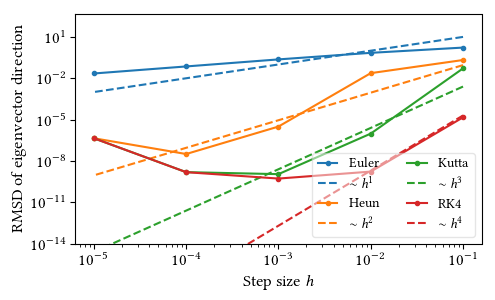

In [166]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [1e2,9e0,2.5e0,2e-1]

for j,err in enumerate(singlestep_xi2_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-25,1e-14)
plot.set_ylim(1e-14,5e2)
leg = plot.legend(loc='lower right', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
#leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Step size $h$',fontsize=12)
plot.set_ylabel(r'RMSD of eigenvector direction',fontsize=12)
plt.tight_layout()
plt.savefig('error_plots/xi2_errors_fixed_steplength.pgf')
plt.savefig('error_plots/xi2_errors_fixed_steplength.png',dpi=350)

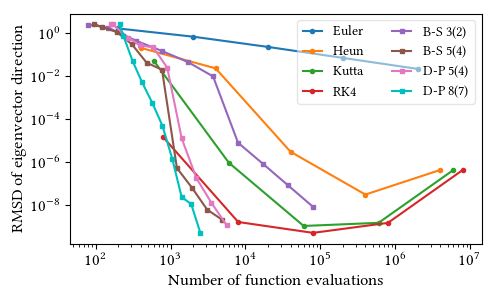

In [167]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_xi2_errs)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations[:-1],embedded_xi2_errs[:-1])):
    plot.plot(evs,err,marker='s',markersize=3,label='{}'.format(enames[j]))

plot.plot(embedded_evaluations[j+1],embedded_xi2_errs[j+1],color='c',marker='s',markersize=3,label='{}'.format(enames[j+1]))
    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='upper right', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Number of function evaluations',fontsize=12)
plot.set_ylabel(r'RMSD of eigenvector direction',fontsize=12)
plt.tight_layout()
plt.savefig('error_plots/xi2_errors_fixed_and_adaptive_steplength.pgf')
plt.savefig('error_plots/xi2_errors_fixed_and_adaptive_steplength.png',dpi=350)

In [48]:
#nlmbderrs = np.empty(np.shape(singlestep_lmbd1_errs))
#for j in range(4):
#    nlmbderrs[j] = [np.mean([singlestep_lmbd1_errs[j][i],singlestep_lmbd2_errs[j][i]]) for i in range(singlestep_lmbd1_errs[j].shape[0])]

In [49]:
#fig = plt.figure(1)
#plot = fig.add_subplot(111)

#names = ['Euler','Heun','Kutta','RK4']
#scales = [5e4,2.5e4,8e3,1.4e3]

#for j,err in enumerate(nlmbderrs):
#    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
#    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
#plot.tick_params(axis='both', which='major', labelsize=20)
#plot.tick_params(axis='both', which='minor', labelsize=10)
#plot.set_yscale('log')
#plot.set_xscale('log')
#plot.set_ylim(1e-9,1e5)
#plot.legend(loc='lower right', ncol=2,fontsize=20,markerscale=1)
#plot.set_xlabel(r'Step size $h$',fontsize=20)
#plot.set_ylabel(r'Mean error in $\lambda$',fontsize=20)
#plt.tight_layout()
#plt.savefig('error_plots/eigenvalue_errors_fixed_steplength.png',dpi=100)

# Error in LCSs

In [149]:
singlestep_lcs_errs = [np.load('errors/{}/lcs_errs_rms.npy'.format(integrator.__name__)) for integrator in singlestep_integrators]
embedded_lcs_errs = [np.load('errors/{}/lcs_errs_rms.npy'.format(integrator.__name__)) for integrator in embedded_integrators]

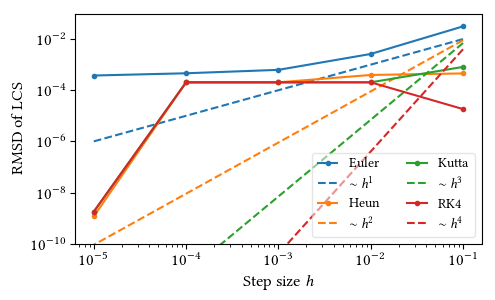

In [89]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

names = ['Euler','Heun','Kutta','RK4']
scales = [1e-1,9e-1,7e0,4e1]

for j,err in enumerate(singlestep_lcs_errs):
    l,=plot.plot(hs,err,marker='.',label='{}'.format(names[j]))
    plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
plot.set_ylim(1e-10,1e-1)
#plot.set_ylim(1e-16,1)
leg = plot.legend(loc='best', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Step size $h$',fontsize=12)
plot.set_ylabel(r'RMSD of LCS',fontsize=12)
plt.tight_layout()
plt.savefig('error_plots/lcs_errors_fixed_steplength.pgf')

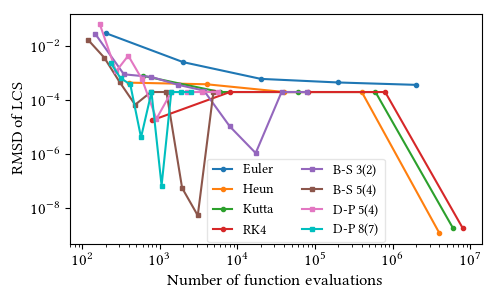

In [151]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

snames = ['Euler','Heun','Kutta','RK4']
enames = ['B-S 3(2)','B-S 5(4)','D-P 5(4)','D-P 8(7)']

for j,(evs,err) in enumerate(zip(singlestep_evaluations,singlestep_lcs_errs)):
    plot.plot(evs,err,marker='.',label='{}'.format(snames[j]))
for j,(evs,err) in enumerate(zip(embedded_evaluations[:-1],embedded_lcs_errs[:-1])):
    plot.plot(evs,err,marker='s',markersize=3,label='{}'.format(enames[j]))
plot.plot(embedded_evaluations[j+1],embedded_lcs_errs[j+1],color='c',marker='s',markersize=3,label='{}'.format(enames[j+1]))

    #plot.plot(hs,scales[j]*hs**(j+1),'--',c=l.get_color(),label=r'$\sim h^{}$'.format(j+1))
    
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_yscale('log')
plot.set_xscale('log')
#plot.set_ylim(1e-16,1)
leg = plot.legend(bbox_to_anchor=(0.55, -0.025),loc='lower center', ncol=2,fontsize=10,markerscale=1,handlelength=1.4)
leg.get_frame().set_alpha(0.5)
plot.set_xlabel(r'Number of function evaluations',fontsize=12)
plot.set_ylabel(r'RMSD of LCS',fontsize=12)
plt.tight_layout()
plt.savefig('error_plots/lcs_errors_fixed_and_adaptive_steplength.pgf')

In [ ]:
print(chr(958))

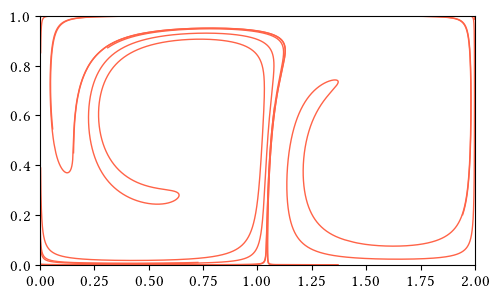

In [33]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)
for LCS in LCS_ref:
    plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],c='tomato',lw=1,label=r'Reference')
#for j in range(8,-1,-1):
#    plot.scatter(trajs[j][0],trajs[j][1],s=1.,marker='.',label=r'tol $={}$'.format(tolerances[j+1]))

    
#plot.legend(bbox_to_anchor=(0.75, 0.8), loc='upper left', ncol=1,fontsize=25,markerscale=8)
#leg.get_frame().set_alpha(0.5)
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plt.xlim(0,2)
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('lcs_figures/reference.pgf')
#plt.savefig('lcs_figures/reference.png',dpi=350)

In [ ]:
LCS_ref.shape

# Plot reference FTLE and $\lambda_{2}(\vec{x}_{0}))$ distribution

In [28]:
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    
    
    
    return mpl.colors.LinearSegmentedColormap.from_list(cmap.name + "_grayscale", colors, cmap.N)

In [33]:
g_viridis = grayify_cmap('plasma')

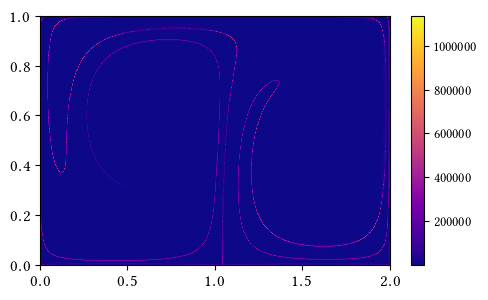

In [36]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)


surf = plot.pcolormesh(grid.reshape(2,nx,ny)[0,:,0],grid.reshape(2,nx,ny)[1,0,:],lmbd2_ref.reshape(nx,ny).T,cmap='plasma')
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_xlim(0,2)
plot.set_ylim(0,1)
bar = fig.colorbar(surf)#labelsize=20)
tcks = [j*150000 for j in range(11)]
bar.ax.tick_params(labelsize=10)
#bar.set_ticks(tcks)
#bar.set_ticklabels(tcks)
plt.tight_layout()

plt.savefig('ftle_l2/l2.png',dpi=350)

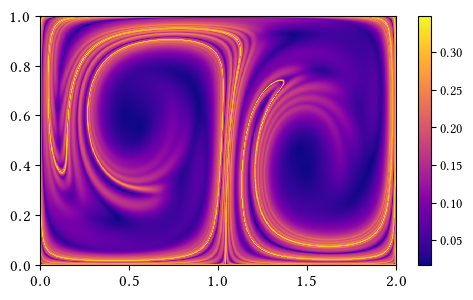

In [40]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)


surf = plot.pcolormesh(grid.reshape(2,nx,ny)[0,:,0],grid.reshape(2,nx,ny)[1,0,:],np.log(lmbd2_ref.reshape(nx,ny).T+1)/(2*(t_end-t_start)),cmap='plasma')
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_xlim(0,2)
plot.set_ylim(0,1)
tcks = [j*0.05 for j in range(8)]
bar = fig.colorbar(surf)#labelsize=20)
bar.ax.tick_params(labelsize=10)
#bar.set_ticks(tcks)
#bar.set_ticklabels(tcks)
plt.tight_layout()

#plt.savefig('ftle_l2/ftle.png',dpi=350)

# Plot $\mathcal{U}_{0}$ domains

In [14]:
def find_ab_mask(lmbd1,lmbd2,hess_lmbd2,xi2):
    return np.logical_and(_a_true(lmbd1,lmbd2),_b_true(hess_lmbd2,xi2))

def _a_true(lmbd1,lmbd2):
    return np.logical_and(np.less(lmbd1,lmbd2),np.greater(lmbd2,1))

def _b_true(hess_lmbd2,xi2):
    #tf = np.zeros(hess_lmbd2.shape[0],dtype=np.bool)
    #for j in range(len(tf)):
    #    if np.dot(xi2[j],np.dot(hess_lmbd2[j],xi2[j])) <=0:
    #        tf[j] = True
    #return tf
    return np.less_equal(np.sum(xi2*np.sum(hess_lmbd2*xi2[...,np.newaxis],axis=1),axis=1),0)

In [51]:
mask_ab = find_ab_mask(lmbd1_ref,lmbd2_ref,hess_lmbd2_ref,xi2_ref)

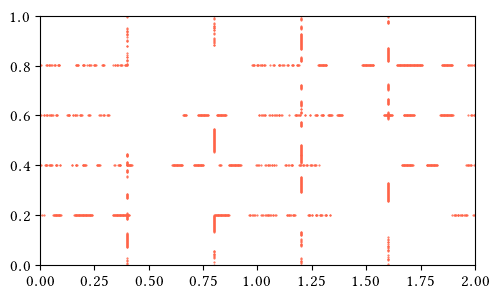

In [61]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)

cm = mpl.colors.ListedColormap(['white','tomato'])

#plot.pcolormesh(grid.reshape(2,nx,ny)[0,:,0],grid.reshape(2,nx,ny)[1,0,:],msk_g0.reshape(nx,ny).T,cmap=cm)
plt.scatter(g0[0],g0[1],s=1,marker='.',c='tomato')
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_xlim(0,2)
plot.set_ylim(0,1)
#bar.set_ticks(tcks)
#bar.set_ticklabels(tcks)
plt.tight_layout()

plt.savefig('domain_figures/g0_dom.png',dpi=350)

In [57]:
def find_g0(nx,ny,num_horz,num_vert):
    mask = np.zeros((nx,ny),dtype=bool)
    stride_horz = np.floor(nx/(num_horz+1)).astype(int)
    stride_vert = np.floor(ny/(num_vert+1)).astype(int)
    
    for j in range(1,num_vert+1):
        mask[np.minimum(j*stride_horz,nx-1),:] = True
    for j in range(1,num_horz+1):
        mask[:,np.minimum(j*stride_vert,ny-1)] = True
    
    mask = mask.reshape(nx*ny)
    
    return mask

In [59]:
num_horz_g0 = 4
num_vert_g0 = 4
msk_g0 = np.logical_and(find_g0(nx,ny,num_horz_g0,num_vert_g0),mask_ab)
g0 = grid[:,np.logical_and(find_g0(nx,ny,num_horz_g0,num_vert_g0),mask_ab)]

# Plot erronous $\mathcal{U}_{0}$ domains

Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.260669708251953 seconds


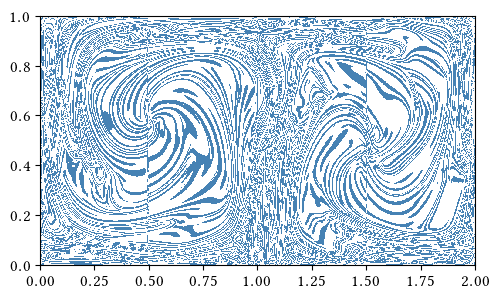

In [33]:
tolz = 1e-1
cm = mpl.colors.ListedColormap(['white','steelblue'])
j_int = 0
integrator = embedded_integrators[j_int]
#for integrator in embedded_integrators:
grid_fin,lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride=0.1,n_proc=4,atol=tolz,rtol=tolz)
msk_ba = find_ab_mask(lmbd1,lmbd2,hess_lmbd2,xi2)

fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)



plot.pcolormesh(grid.reshape(2,nx,ny)[0,:,0],grid.reshape(2,nx,ny)[1,0,:],msk_ba.reshape(nx,ny).T,cmap=cm)
#plt.scatter(g0[0],g0[1],s=1,marker='.',c='tomato')
plot.tick_params(axis='both', which='major', labelsize=12)
plot.tick_params(axis='both', which='minor', labelsize=10)
plot.set_xlim(0,2)
plot.set_ylim(0,1)
#bar.set_ticks(tcks)
#bar.set_ticklabels(tcks)
plt.tight_layout()

#plt.savefig('domain_figures/{}_tol=0.1.png'.format(integrator.__name__),dpi=350)

#fig2 = plt.figure(2,figsize=(2.525,1.55))
#plot = fig2.add_subplot(111)



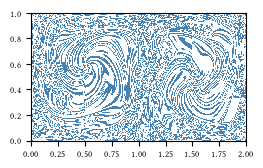

In [34]:
fig = plt.figure(1,figsize=(2.525,1.55))
plot = fig.add_subplot(111)
fig.subplots_adjust(hspace=0,wspace=0)

plot.pcolormesh(grid.reshape(2,nx,ny)[0,:,0],grid.reshape(2,nx,ny)[1,0,:],msk_ba.reshape(nx,ny).T,cmap=cm)
#plt.scatter(g0[0],g0[1],s=1,marker='.',c='tomato')
plot.tick_params(axis='both', which='major', labelsize=6)
plot.tick_params(axis='both', which='minor', labelsize=5)
plot.set_xlim(0,2)
plot.set_ylim(0,1)
#bar.set_ticks(tcks)
#bar.set_ticklabels(tcks)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.125)

plt.savefig('domain_figures/{}_err_half_width.png'.format(integrator.__name__),dpi=350)

In [55]:
DP_LCS = [np.load('precomputed_lcs/rkdp87/lcs_atol={}_rtol={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(h,h)) for h in [1e-05,1e-06,1e-07,1e-08]]

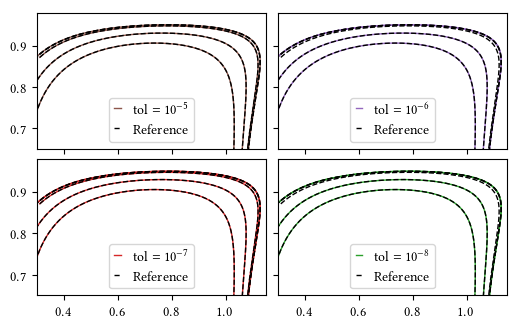

In [180]:
fig = plt.figure(1,figsize=(5.05,3.1))
plotll = plt.subplot(223)
plotlr = plt.subplot(224)
plotul = plt.subplot(221)
plotur = plt.subplot(222)
plotul.plot(0,0)
plotul.plot(0,0)
plotul.plot(0,0)
plotul.plot(0,0)
plotul.plot(0,0)
l,=plotul.plot(DP_LCS[0][0].tailcut_traj()[0],DP_LCS[0][0].tailcut_traj()[1],lw=1,label=r'$\textnormal{tol}=10^{-5}$')
for slurmline in DP_LCS[0][3:5]:
    plotul.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')
plotur.plot(0,0)
plotur.plot(0,0)
plotur.plot(0,0)
plotur.plot(0,0)
l,=plotur.plot(DP_LCS[1][3].tailcut_traj()[0],DP_LCS[1][3].tailcut_traj()[1],lw=1,label=r'$\textnormal{tol}=10^{-6}$')
for slurmline in [DP_LCS[1][4],DP_LCS[1][6]]:
    plotur.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')
plotll.plot(0,0)
plotll.plot(0,0)
plotll.plot(0,0)
l, = plotll.plot(DP_LCS[2][0].tailcut_traj()[0],DP_LCS[2][0].tailcut_traj()[1],lw=1,label=r'$\textnormal{tol}=10^{-7}$')
for slurmline in [DP_LCS[2][3],DP_LCS[2][4],DP_LCS[2][6]]:
    plotll.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')
plotlr.plot(0,0)
plotlr.plot(0,0)
l, = plotlr.plot(DP_LCS[3][3].tailcut_traj()[0],DP_LCS[3][3].tailcut_traj()[1],lw=1,label=r'$\textnormal{tol}=10^{-8}$')
for slurmline in [DP_LCS[3][4],DP_LCS[3][6]]:
    plotlr.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')

plotul.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],'--',lw=1,c='k',label='Reference')
plotur.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],'--',lw=1,c='k',label='Reference')
plotlr.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],'--',lw=1,c='k',label='Reference')
plotll.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],'--',lw=1,c='k',label='Reference')
for slurmline in LCS_ref[1:]:
    plotul.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],'--',lw=1,c='k',label='_nolegend_')
    plotur.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],'--',lw=1,c='k',label='_nolegend_')
    plotlr.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],'--',lw=1,c='k',label='_nolegend_')
    plotll.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],'--',lw=1,c='k',label='_nolegend_')

plotul.set_xlim(0.3,1.15)
plotul.set_ylim(0.65,0.98)
plotur.set_xlim(0.3,1.15)
plotur.set_ylim(0.65,0.98)
plotll.set_xlim(0.3,1.15)
plotll.set_ylim(0.65,0.98)
plotlr.set_xlim(0.3,1.15)
plotlr.set_ylim(0.65,0.98)
legul = plotul.legend(loc='lower center',ncol=1,fontsize=10,markerscale=4,handlelength=0.5)
legur = plotur.legend(loc='lower center',ncol=1,fontsize=10,markerscale=4,handlelength=0.5)
leglr = plotlr.legend(loc='lower center',ncol=1,fontsize=10,markerscale=4,handlelength=0.5)
legll = plotll.legend(loc='lower center',ncol=1,fontsize=10,markerscale=4,handlelength=0.5)
fig.subplots_adjust(hspace=0.075,wspace=0.05)
plt.setp(plotul.get_xticklabels(),visible=False)
plt.setp(plotur.get_xticklabels(),visible=False)
plt.setp(plotur.get_yticklabels(),visible=False)
plt.setp(plotlr.get_yticklabels(),visible=False)
#plt.tight_layout()
plt.subplots_adjust(left=0.06, right=0.992, top=0.992, bottom=0.08)
plt.savefig('/home/arne/Desktop/derpert.png',dpi=350)
plt.savefig('error_plots/lcs_error_oscillations.pgf')

In [ ]:
#fig = plt.figure(1,figsize=(5.05,3.1))
#plot = fig.add_subplot(111)
##l, = plot.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],lw=1,c='tomato',label=r'\textnormal{Reference}')
##for LCS in LCS_ref[1:]:
##    plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')  
#j_int = 3
#integrator = embedded_integrators[j_int]
#for counter,tol in enumerate(tolerances[9:0:-1]):
#    LCS_curr = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter=10000_stride=0.001_l_f_max=0.2_l_min=1.0_tol_alpha=1e-06.npy'.format(integrator.__name__,tol,tol))
#    l, = plot.plot(LCS_curr[0].tailcut_traj()[0],LCS_curr[0].tailcut_traj()[1],lw=1,label=r'$\textnormal{{tol}}=10^{{{{-}}{}}}$'.format(10-counter))
#    for LCS in LCS_curr[1:]:
#        plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')
#l, = plot.plot(LCS_ref[0].tailcut_traj()[0],LCS_ref[0].tailcut_traj()[1],':',lw=1,c='k',label=r'\textnormal{Reference}')
#for LCS in LCS_ref[1:]:
#    plot.plot(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],':',lw=1,c=l.get_color(),label='_nolegend_')  
#
#        
#leg = plot.legend(bbox_to_anchor=(0.725, 0.99), loc='upper left', ncol=1,fontsize=10,markerscale=4,handlelength=0.5)
#leg.get_frame().set_alpha(0.5)
#plot.tick_params(axis='both', which='major', labelsize=12)
#plot.tick_params(axis='both', which='minor', labelsize=10)
#plt.xlim(0,2)
#plt.ylim(0,1)
#plt.tight_layout()
#plt.savefig('lcs_figures/{}.pgf'.format(integrator.__name__))
##plt.savefig('lcs_figures/{}.png'.format(integrator.__name__),dpi=350)


(-0.05, 2.05)

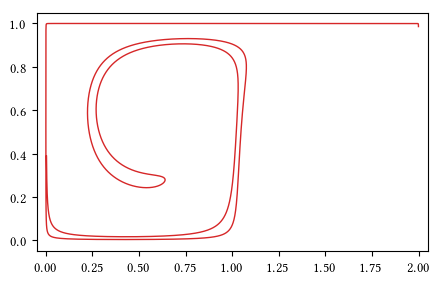

In [227]:
fig = plt.figure(1,figsize=(5.05,3.1))
plot = fig.add_subplot(111)
plot.plot(0,0)
plot.plot(0,0)
plot.plot(0,0)
plot.plot(0,0)
plot.plot(0,0)
n = 3
#l,=plot.plot(DP_LCS[0][0].tailcut_traj()[0],DP_LCS[0][0].tailcut_traj()[1],lw=1,label=r'$\textnormal{tol}=10^{-5}$')
for slurmline in LCS_ref[n:n+1]:
    plot.plot(slurmline.tailcut_traj()[0],slurmline.tailcut_traj()[1],lw=1,c=l.get_color(),label='_nolegend_')
plot.set_xlim(-0.05,2.05)

In [ ]:
# DP_LCS[0]: 0,3,4
# DP_LCS[1]: 3,4,6
# DP_LCS[2]: 0,3,4,6
# DP_LCS[3]: 3,4,6,

In [220]:
LCS_ref[0].tailcut_avg_lmbd2()

239917.13295114678

In [228]:
LCS_ref[3].tailcut_avg_lmbd2()

151715.40568693331